In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cmpe import CMPE

from data_generators import *
from positional_encoders import *
from plotters import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [6]:
dx, dy, dg, dpe = 1, 1, 1, 27
num_demos, num_test = 32, 8
num_trajs = num_demos + num_test
t_steps = 1000
n_max, m_max = 100, 100
max_y = 0.2

all_x_train, all_x_test, all_y_train, all_y_test, all_g_train, all_g_test, all_test_cond = [], [], [], [], [], [], []
all_x, all_y = [], []

for i in range(3):
    num_peaks = 2+i

    x, y, pp = n_peaks(num_peaks, num_trajs, 0.05-i**2/100, t_steps)
    all_x.append(x)
    y_max, y_min = torch.max(y), torch.min(y)
    y = (y - y_min) / (y_max - y_min) * max_y
    all_y.append(y)

    # train-test split
    test_ids = []
    while len(test_ids) < num_test:
        val_id = np.random.choice(np.arange(num_trajs), 1)
        # continue if pp[val_id] is either smallest or largest value
        # append to val_id otherwise
        if (pp[val_id, 0] == torch.max(pp[:, 0]) or pp[val_id, 0] == torch.min(pp[:, 0])):
            continue
        else:
            if val_id not in test_ids:
                test_ids.append(val_id)

    train_ids = np.setdiff1d(np.arange(num_trajs), test_ids)
    test_ids = torch.tensor(test_ids).squeeze(-1)
    train_ids = torch.from_numpy(train_ids)

    all_test_cond.append((pp[test_ids] * 200).int())

    # y_diff = y[:,1:] - y[:,:-1]
    # x_diff = x[:, 1:]

    # all_y_train.append(y_diff[train_ids].clone())
    # all_y_test.append(y_diff[test_ids].clone())

    # all_x_train.append(x_diff[train_ids].clone())
    # all_x_test.append(x_diff[test_ids].clone())
    all_y_train.append(y[train_ids].clone())
    all_y_test.append(y[test_ids].clone())

    all_x_train.append(x[train_ids].clone())
    all_x_test.append(x[test_ids].clone())

    all_g_train.append(num_peaks * torch.ones(len(train_ids), 1).int())
    all_g_test.append(num_peaks * torch.ones(len(test_ids), 1).int())

num_demos, num_test = 3*32, 3*8
num_trajs = num_demos + num_test

y_train = torch.cat(all_y_train, dim=0)
y_test = torch.cat(all_y_test, dim=0)
x_train = torch.cat(all_x_train, dim=0)
x_test = torch.cat(all_x_test, dim=0)
g_train = torch.cat(all_g_train, dim=0) / 4  # Normalize where max_peaks = 4
g_test = torch.cat(all_g_test, dim=0) / 4  # Normalize where max_peaks = 4
test_cond_ind = all_test_cond

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, g_train shape: {g_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}, g_test shape: {g_test.shape}")

all_x = torch.cat(all_x, dim=0)
all_y = torch.cat(all_y, dim=0)

x_train shape: torch.Size([96, 1000, 1]), y_train shape: torch.Size([96, 1000, 1]), g_train shape: torch.Size([96, 1])
x_test shape: torch.Size([24, 1000, 1]), y_test shape: torch.Size([24, 1000, 1]), g_test shape: torch.Size([24, 1])


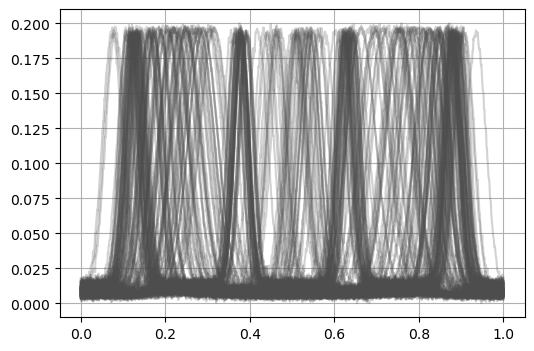

In [7]:
plot_trajs(all_x, all_y)

In [4]:
# plot_train_test(num_demos, x_train, y_train, num_test, x_test, y_test)

In [8]:
batch_size = 8
window_length = 10

enc_dims = [256,128]
dec_dims = [128,128]

cmpe_ = CMPE(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, window_length=window_length, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=cmpe_.parameters())

pytorch_total_params = sum(p.numel() for p in cmpe_.parameters())
print('CMPE: ', pytorch_total_params)


if torch.__version__ >= "2.0":
    cmpe = torch.compile(cmpe_)
else:
    cmpe = cmpe_

CMPE:  347138


In [9]:
d_model = dpe
pe_code = 0
pe = pes[pe_code](length=t_steps, d_model=d_model)

In [10]:
dpe_aug = dpe + dg  # dg for gamma (peak_positions)

obs = torch.zeros((batch_size, n_max, window_length, dpe_aug+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max+1, (1,)).item()
        m = torch.randint(1, m_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps-window_length)  # e.g 1000-10 = 990, n_id can be 990 at max since we are using window_length=10
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        for j in range(window_length):
            obs[i, :n, j, :dpe] = pe[n_ids+j] # PE(t)
            obs[i, :n, j, dpe:dpe_aug] = g_train[traj_id, 0] # gamma(t)
            obs[i, :n, j, dpe_aug:] = traj[n_ids+j]  # SM(t), SM(t+1), SM(t+2), ..., SM(t+(window_length-1))
        # obs[i, :n, dpe_aug:] = traj[n_ids]
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dpe] = pe[m_ids]
        tar_x[i, :m, dpe:dpe_aug] = g_train[traj_id, 0]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

test_obs = torch.zeros((batch_size, n_max, window_length, dpe_aug+dy), dtype=torch.float32, device=device)
test_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
test_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
test_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
last_obs_vals = torch.zeros((batch_size, n_max, dx), dtype=torch.int32, device=device)  # only for plotting

def prepare_masked_test_batch(t: list, traj_ids: list, fixed_ind=None):
    test_obs.fill_(0)
    test_tar_x.fill_(0)
    test_tar_y.fill_(0)
    test_obs_mask.fill_(False)
    last_obs_vals.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        # n = num_peaks #torch.randint(5, n_max, (1,)).item()
        n = torch.randint(1, n_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps-window_length)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)

        # TODO didn't update, so check
        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
            # n_ids[-1] = fixed_ind[i]
        
        for j in range(window_length):
            test_obs[i, :n, j, :dpe] = pe[n_ids+j]
            test_obs[i, :n, j, dpe:dpe_aug] = g_test[traj_id, 0]
            test_obs[i, :n, j, dpe_aug:] = traj[n_ids+j]
        last_obs_vals[i, :n] = n_ids.unsqueeze(-1)
        # test_obs[i, :n, dpe_aug:] = traj[n_ids]
        test_obs_mask[i, :n] = True
        
        test_tar_x[i, :, :dpe] = pe
        test_tar_x[i, :, dpe:dpe_aug] = g_test[traj_id, 0]
        test_tar_y[i] = traj[m_ids]

In [11]:
import time
import os

peak_code = ('no' if dpe_aug==dpe else 'with') + '_num_peaks'
# arch_code = str(num_demos) + '_' + str(num_test) + '_'
# for i in enc_dims:
#     arch_code += str(i) + '_'
# arch_code = arch_code[:-1]

#timestamp = int(time.time())
# root_folder = f'../outputs/tests/{num_peaks}_peak/{pose_code}/{arch_code}/bs_{batch_size}/{str(timestamp)}/'


timestamp = int(time.time())
root_folder = f'../outputs/tests/lstm/{peak_code}/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 500_000
epoch_iter = num_demos // batch_size
test_epoch_iter = num_test//batch_size
avg_loss = 0
loss_report_interval = 500
test_per_epoch = 1000
min_test_loss = 1000000
mse_loss = torch.nn.MSELoss()

plot_test = False

l = []

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()        
        pred = cmpe(obs, tar_x, obs_mask)
        loss = cmpe.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % test_per_epoch == 0 and epoch > 0:
        v_traj_ids = torch.randperm(num_test)[:batch_size*test_epoch_iter].chunk(test_epoch_iter)
        test_loss = 0

        for j in range(test_epoch_iter):
            prepare_masked_test_batch(y_test, v_traj_ids[j])

            pred = cmpe.val(test_obs, test_tar_x, test_obs_mask)
            if plot_test:
                for k in range(batch_size):
                    current_n = test_obs_mask[k].sum().item()
                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs[k, :current_n, 0, dpe_aug:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                    plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                    
                    plt.legend()
                    plt.savefig(f'{img_folder}{epoch}_PEMP_{j}_{k}.png')
                    plt.clf()
            test_loss += mse_loss(pred[:, :, :cmpe.output_dim], test_tar_y).item()
        
        test_loss /= test_epoch_iter
            
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            print(f'New best: {min_test_loss}')
            torch.save(cmpe_.state_dict(), f'{root_folder}saved_models/cmpe.pt')

    epoch_loss /= epoch_iter

    avg_loss += epoch_loss

    l.append(epoch_loss)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, CMPE Loss: {}".format(epoch, avg_loss/loss_report_interval))
        avg_loss = 0

Epoch: 0, CMPE Loss: 0.0008728988021612168
Epoch: 500, CMPE Loss: -2.0916072285429905
New best: 0.0014244015328586102
Epoch: 1000, CMPE Loss: -2.5745392750700336
Epoch: 1500, CMPE Loss: -2.6679548073311667
New best: 0.0013609805221979816
Epoch: 2000, CMPE Loss: -2.7431539919475703
Epoch: 2500, CMPE Loss: -2.8058691998422165
New best: 0.0013408119945476453
Epoch: 3000, CMPE Loss: -2.795032252326609
Epoch: 3500, CMPE Loss: -2.8707170123855303
Epoch: 4000, CMPE Loss: -2.640324887007478


KeyboardInterrupt: 

In [10]:
torch.save(l, f'{root_folder}losses.pt')